In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate


In [0]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [4]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
adc.json  drive  sample_data


**Part B Question 1 - Character CNN Classifier**

In [0]:
import numpy as np
import pandas
import csv
import pylab as plt
import tensorflow as tf

In [0]:
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
EMBEDDING_SIZE = 20
HIDDEN_SIZE = 20

epochs = 200
lr = 0.01
batch_size = 128

tf.logging.set_verbosity(tf.logging.ERROR)
seed = 10
tf.set_random_seed(seed)

In [0]:
def char_cnn_model(x):
  FILTER_SHAPE1 = [20, 256]
  FILTER_SHAPE2 = [20, 1]
  input_layer = tf.reshape(
      tf.one_hot(x, 256), [-1, MAX_DOCUMENT_LENGTH, 256, 1])

#   with tf.variable_scope('CNN_Layer1'):
  conv1 = tf.layers.conv2d(
      input_layer,
      filters=N_FILTERS,
      kernel_size=FILTER_SHAPE1,
      padding='VALID',
      activation=tf.nn.relu)
  pool1 = tf.layers.max_pooling2d(
      conv1,
      pool_size=POOLING_WINDOW,
      strides=POOLING_STRIDE,
      padding='SAME')
  pool1_dropout = tf.nn.dropout(pool1, keep_prob)

#   with tf.variable_scope('CNN_Layer2'):
  conv2 = tf.layers.conv2d(
      pool1_dropout,
      filters=N_FILTERS,
      kernel_size=FILTER_SHAPE2,
      padding='VALID',
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(
      conv2,
      pool_size=POOLING_WINDOW,
      strides=POOLING_STRIDE,
      padding='SAME')
  pool2_dropout = tf.nn.dropout(pool2, keep_prob)
  
  pool2_squeeze = tf.squeeze(tf.reduce_max(pool2_dropout, 1), squeeze_dims=[1])

  logits = tf.layers.dense(pool2_squeeze, MAX_LABEL, activation=None)

  return logits

In [0]:
def read_data_chars():
  
  x_train, y_train, x_test, y_test = [], [], [], []

  with open('drive/NeuralNetsProject2-DATA/train/train_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      x_train.append(row[1])
      y_train.append(int(row[0]))

  with open('drive/NeuralNetsProject2-DATA/test/test_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      x_test.append(row[1])
      y_test.append(int(row[0]))
  
  x_train = pandas.Series(x_train)
  y_train = pandas.Series(y_train)
  x_test = pandas.Series(x_test)
  y_test = pandas.Series(y_test)
  
  
  char_processor = tf.contrib.learn.preprocessing.ByteProcessor(MAX_DOCUMENT_LENGTH)
  x_train = np.array(list(char_processor.fit_transform(x_train)))
  x_test = np.array(list(char_processor.transform(x_test)))
  y_train = y_train.values
  y_test = y_test.values
  
  return x_train, y_train, x_test, y_test

In [0]:
x_train, y_train, x_test, y_test = read_data_chars()

iter: 199, entropy: 0.0433558, testing accuracy: 0.417143

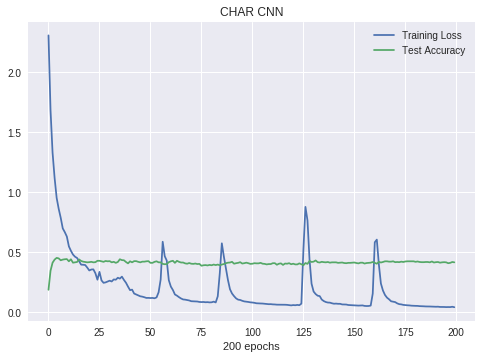

In [113]:

# print(len(x_train))
# print(len(x_test))

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)
keep_prob = tf.placeholder(tf.float32)

logits = char_cnn_model(x)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

# Testing
correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(x_train)
idx = np.arange(N)

# training
training_loss = []
testing_acc = []
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  for e in range(epochs):
    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]
    for start in range(0, N-batch_size, batch_size):
      train_op.run(feed_dict={x: x_train[start: start+batch_size], y_: y_train[start: start+batch_size], keep_prob:1})

    loss_ = entropy.eval(feed_dict={x: x_train, y_: y_train, keep_prob:1})
    acc_ = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob:1})
    training_loss.append(loss_)
    testing_acc.append(acc_)


    if e%1 == 0:
      print('\riter: %d, entropy: %g, testing accuracy: %g'%(e, training_loss[e], testing_acc[e]), end='')


plt.figure()
plt.plot(range(epochs), training_loss)
plt.plot(range(epochs), testing_acc)
plt.title("CHAR CNN")
plt.xlabel(str(epochs)+' epochs')
plt.legend(["Training Loss", "Test Accuracy"])
plt.savefig('drive/NeuralNetsProject2/figures/partb/q1_figure.png')    


**Part B Question 2 - Word CNN Classifier**

In [0]:
def data_read_words():
  
  x_train, y_train, x_test, y_test = [], [], [], []
  
  with open('drive/NeuralNetsProject2-DATA/train/train_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      x_train.append(row[2])
      y_train.append(int(row[0]))

  with open("drive/NeuralNetsProject2-DATA/test/test_medium.csv", encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      x_test.append(row[2])
      y_test.append(int(row[0]))
  
  x_train = pandas.Series(x_train)
  y_train = pandas.Series(y_train)
  x_test = pandas.Series(x_test)
  y_test = pandas.Series(y_test)
  y_train = y_train.values
  y_test = y_test.values
  
  vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
      MAX_DOCUMENT_LENGTH)

  x_transform_train = vocab_processor.fit_transform(x_train)
  x_transform_test = vocab_processor.transform(x_test)

  x_train = np.array(list(x_transform_train))
  x_test = np.array(list(x_transform_test))

  no_words = len(vocab_processor.vocabulary_)
#   print('Total words: %d' % no_words)

  return x_train, y_train, x_test, y_test, no_words

In [0]:
global n_words
x_train, y_train, x_test, y_test, n_words = data_read_words()
tf.reset_default_graph() 

In [0]:
def word_cnn_model(x):
  FILTER_SHAPE1 = [20, 20]
  FILTER_SHAPE2 = [20, 1]
  with tf.variable_scope('CNN_WORD'):
    word_vectors = tf.contrib.layers.embed_sequence(
        x, vocab_size=n_words, embed_dim=EMBEDDING_SIZE)


    input_layer = tf.reshape(
        word_vectors, [-1, MAX_DOCUMENT_LENGTH, EMBEDDING_SIZE, 1])

    conv1 = tf.layers.conv2d(
        input_layer,
        filters=N_FILTERS,
        kernel_size=FILTER_SHAPE1,
        padding='VALID',
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(
        conv1,
        pool_size=POOLING_WINDOW,
        strides=POOLING_STRIDE,
        padding='SAME')
    pool1_dropout = tf.nn.dropout(pool1, keep_prob)

    conv2 = tf.layers.conv2d(
        pool1_dropout,
        filters=N_FILTERS,
        kernel_size=FILTER_SHAPE2,
        padding='VALID',
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(
        conv2,
        pool_size=POOLING_WINDOW,
        strides=POOLING_STRIDE,
        padding='SAME')
    pool2_dropout = tf.nn.dropout(pool2, keep_prob)

    pool2_squeeze = tf.squeeze(tf.reduce_max(pool2_dropout, 1), squeeze_dims=[1])

    logits = tf.layers.dense(pool2_squeeze, MAX_LABEL, activation=None)

    return logits

iter: 199, entropy: 1.75003e-07, testing accuracy: 0.915714

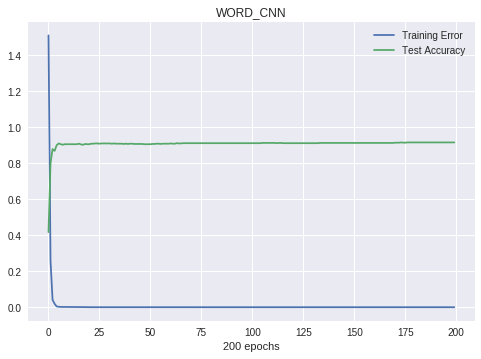

In [11]:
# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)
keep_prob = tf.placeholder(tf.float32)

logits = word_cnn_model(x)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

# Testing
correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(x_train)
idx = np.arange(N)

# training
training_loss = []
testing_acc = []
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  for e in range(epochs):
    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]
    for start in range(0, N-batch_size, batch_size):
      train_op.run(feed_dict={x: x_train[start: start+batch_size], y_: y_train[start: start+batch_size], keep_prob:1})

    loss_ = entropy.eval(feed_dict={x: x_train, y_: y_train, keep_prob:1})
    acc_ = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob:1})
    training_loss.append(loss_)
    testing_acc.append(acc_)


    if e%1 == 0:
      print('\riter: %d, entropy: %g, testing accuracy: %g'%(e, training_loss[e], testing_acc[e]), end='')


plt.figure()
plt.plot(range(epochs), training_loss)
plt.plot(range(epochs), testing_acc)
plt.title("WORD_CNN")
plt.xlabel(str(epochs)+' epochs')
plt.legend(["Training Error","Test Accuracy"])
plt.savefig('drive/NeuralNetsProject2/figures/partb/q2_figure.png')

**Part B Question 3 - Character RNN Classifier**

In [0]:
tf.reset_default_graph() 
x_train, y_train, x_test, y_test = read_data_chars()

In [0]:
def char_rnn_model(x):
  with tf.variable_scope('RNN_CHAR'):
    char_vectors = tf.one_hot(x, 256)

    char_list = tf.unstack(char_vectors, axis=1)
    cell = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE, reuse=tf.get_variable_scope().reuse)
    cell=tf.nn.rnn_cell.DropoutWrapper(
      cell,
      input_keep_prob=1,
      output_keep_prob=keep_prob,
      state_keep_prob=1,
    )
    _, encoding = tf.nn.static_rnn(cell, char_list, dtype=tf.float32)

    logits = tf.layers.dense(encoding, MAX_LABEL, activation=None, reuse=tf.get_variable_scope().reuse)

  return logits

iter: 199, entropy: 0.559483, testing accuracy: 0.414286

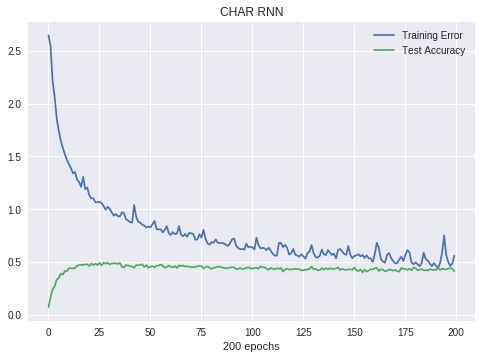

In [120]:
# print(len(x_train))
# print(len(x_test))

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)
keep_prob = tf.placeholder(tf.float32)

logits = char_rnn_model(x)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

# Testing
correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(x_train)
idx = np.arange(N)

# training
training_loss = []
testing_acc = []
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for e in range(epochs):
    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]
    for start in range(0, N-batch_size, batch_size):
      train_op.run(feed_dict={x: x_train[start: start+batch_size], y_: y_train[start: start+batch_size], keep_prob:1})

    loss_ = entropy.eval(feed_dict={x: x_train, y_: y_train, keep_prob:1})
    acc_ = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob:1})
    training_loss.append(loss_)
    testing_acc.append(acc_)


    if e%1 == 0:
      print('\riter: %d, entropy: %g, testing accuracy: %g'%(e, training_loss[e], testing_acc[e]), end='')


plt.figure()
plt.plot(range(epochs), training_loss)
plt.plot(range(epochs), testing_acc)
plt.title("CHAR RNN")
plt.xlabel(str(epochs)+' epochs')
plt.legend(["Training Error", "Test Accuracy"])
plt.savefig('drive/NeuralNetsProject2/figures/partb/q3_figure.png')

**Part B Question 4 RNN Word Classifier**

In [0]:
tf.reset_default_graph() 
x_train, y_train, x_test, y_test, n_words = data_read_words()

In [0]:
def word_rnn_model(x):
  with tf.variable_scope('RNN_WORD'):

    word_vectors = tf.contrib.layers.embed_sequence(
        x, vocab_size=n_words, embed_dim=EMBEDDING_SIZE)

    word_list = tf.unstack(word_vectors, axis=1)
    cell = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE)
    cell=tf.nn.rnn_cell.DropoutWrapper(
      cell,
      input_keep_prob=1,
      output_keep_prob=keep_prob,
      state_keep_prob=1,
    )
    _, encoding = tf.nn.static_rnn(cell, word_list, dtype=tf.float32)

    logits = tf.layers.dense(encoding, MAX_LABEL, activation=None)

  return logits

iter: 199, entropy: 9.278197467210703e-06, testing accuracy: 0.7942857146263123

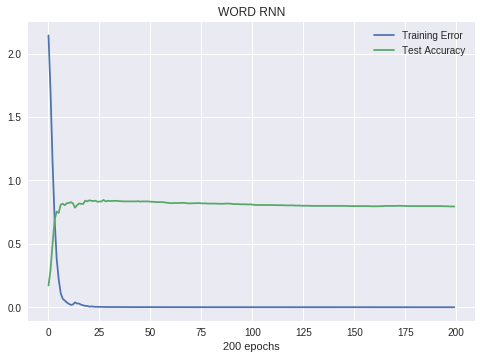

In [14]:
  # Create the model
  x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
  y_ = tf.placeholder(tf.int64)
  keep_prob = tf.placeholder(tf.float32)

  logits = word_rnn_model(x)

  # Optimizer
  entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
  train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

  # Testing
  correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1)), tf.float32)
  accuracy = tf.reduce_mean(correct_prediction)

  N = len(x_train)
  idx = np.arange(N)

  # training
  training_loss = []
  testing_acc = []
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(epochs):
      np.random.shuffle(idx)
      x_train = x_train[idx]
      y_train = y_train[idx]
      for start in range(0, N-batch_size, batch_size):
        train_op.run(feed_dict={x: x_train[start: start+batch_size], y_: y_train[start: start+batch_size], keep_prob:1})

      loss_ = entropy.eval(feed_dict={x: x_train, y_: y_train, keep_prob:1})
      acc_ = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob:1})
      training_loss.append(loss_)
      testing_acc.append(acc_)


      if e%1 == 0:
        print('\riter: {}, entropy: {}, testing accuracy: {}'.format(e, training_loss[e], testing_acc[e]), end='')


plt.figure()
plt.plot(range(epochs), training_loss)
plt.plot(range(epochs), testing_acc)
plt.title("WORD RNN")
plt.xlabel(str(epochs)+' epochs')
plt.legend(["Training Error", "Test Accuracy"])
plt.savefig('drive/NeuralNetsProject2/figures/partb/q4_figure.png')

**Part B Question 5 - Adding Dropout**

In [0]:
dropout_probs = [1.0, 0.8, 0.6, 0.4]
models = [char_cnn_model, word_cnn_model, char_rnn_model, word_rnn_model]
models_ = ["char_cnn", "word_cnn", "char_rnn", "word_rnn"]

Model: char_cnn, dropout: 1.0, test accuracy: 0.3742857277393341
Model: word_cnn, dropout: 1.0, test accuracy: 0.8757143020629883
Model: char_rnn, dropout: 1.0, test accuracy: 0.4714285731315613
Model: word_rnn, dropout: 1.0, test accuracy: 0.8385714292526245
Model: char_cnn, dropout: 0.8, test accuracy: 0.404285728931427
Model: word_cnn, dropout: 0.8, test accuracy: 0.8942857384681702
Model: char_rnn, dropout: 0.8, test accuracy: 0.47428572177886963
Model: word_rnn, dropout: 0.8, test accuracy: 0.8500000238418579
Model: char_cnn, dropout: 0.6, test accuracy: 0.40857142210006714
Model: word_cnn, dropout: 0.6, test accuracy: 0.8657143115997314
Model: char_rnn, dropout: 0.6, test accuracy: 0.47285714745521545
Model: word_rnn, dropout: 0.6, test accuracy: 0.8299999833106995
Model: char_cnn, dropout: 0.4, test accuracy: 0.38285714387893677
Model: word_cnn, dropout: 0.4, test accuracy: 0.8071428537368774
Model: char_rnn, dropout: 0.4, test accuracy: 0.4628571569919586
Model: word_rnn, dropo

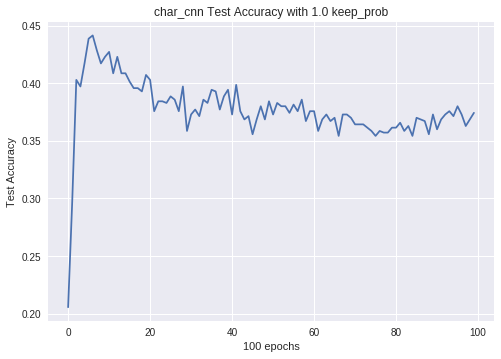

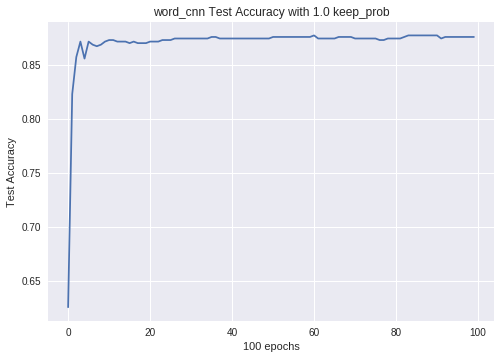

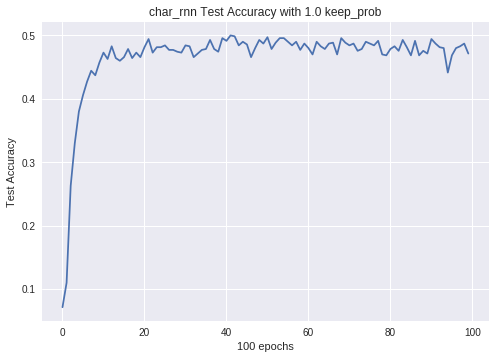

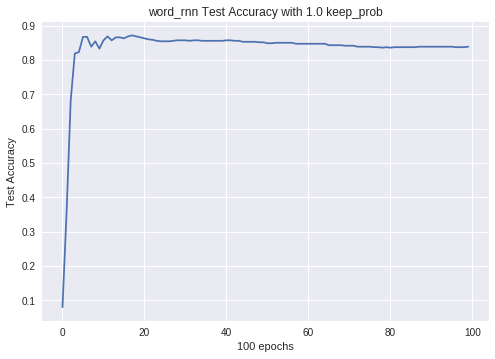

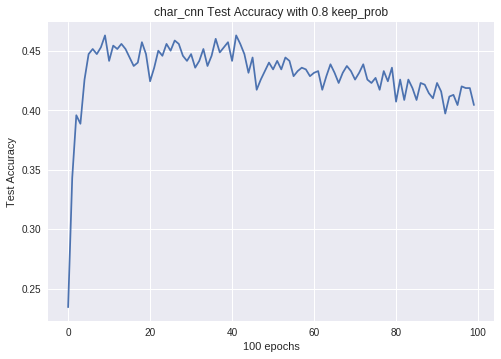

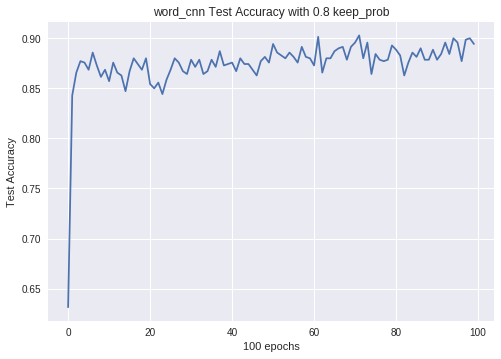

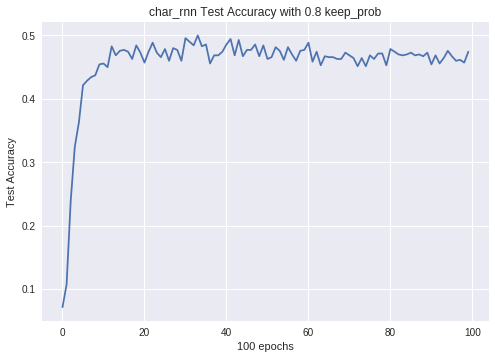

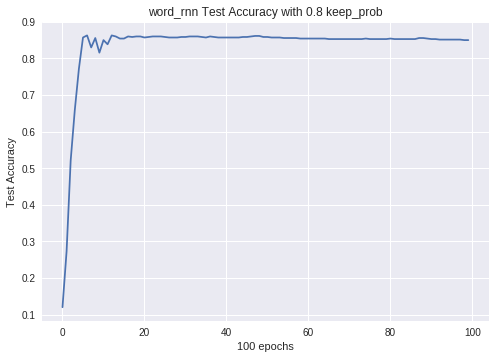

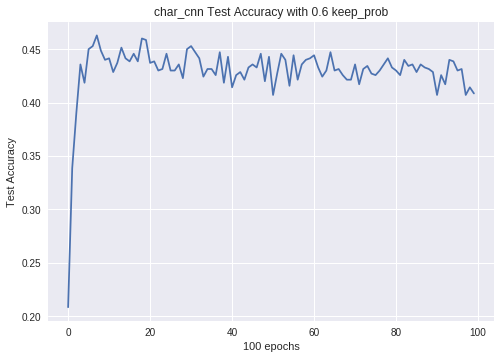

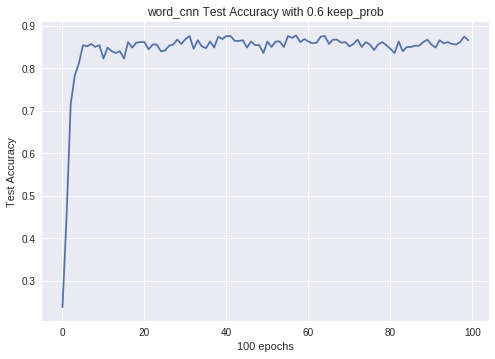

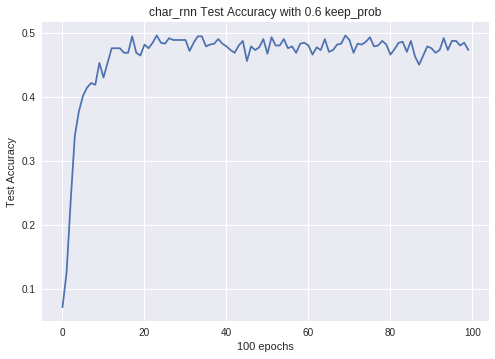

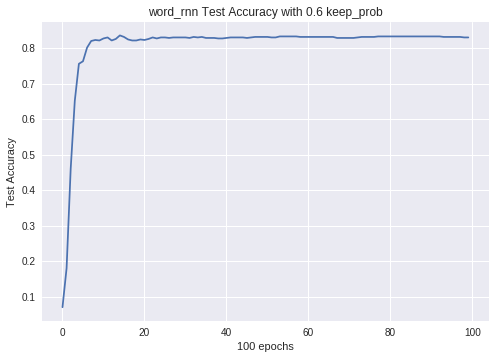

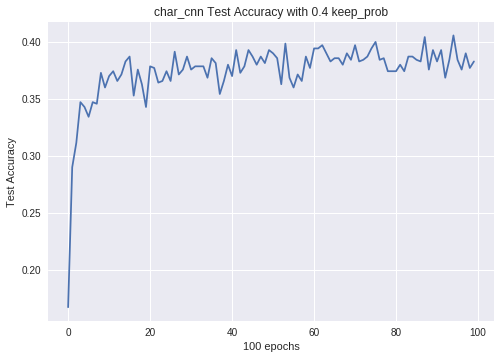

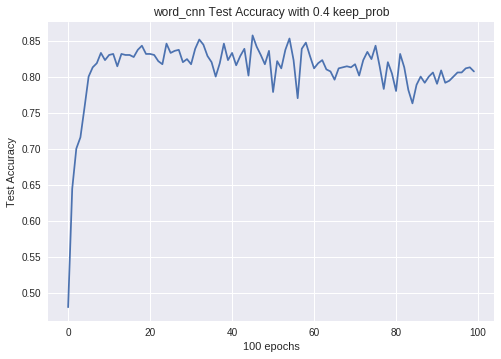

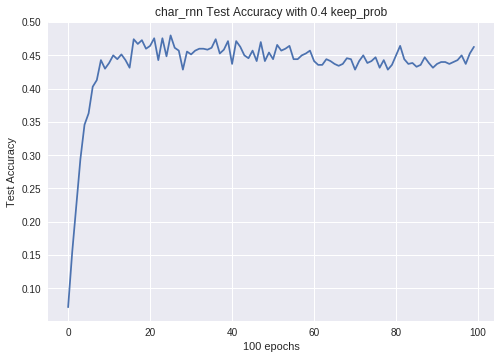

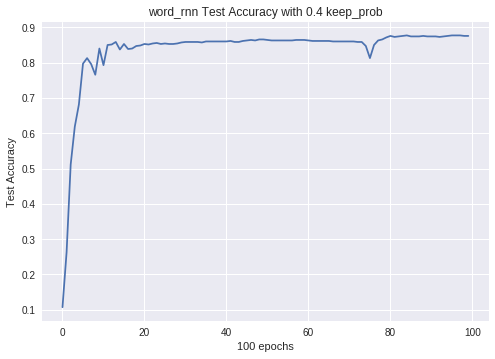

In [181]:
for dropout in dropout_probs:
  for index, model in enumerate(models): 
    
    if index%2 == 0:
      x_train, y_train, x_test, y_test = read_data_chars()
    else:
      x_train, y_train, x_test, y_test, n_words = data_read_words()
    
    x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
    y_ = tf.placeholder(tf.int64)
    keep_prob = tf.placeholder(tf.float32)

    logits = model(x)

    # Optimizer
    entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
    train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

    # Testing
    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
      
    N = len(x_train)
    idx = np.arange(N)

    # training
    training_loss = []
    testing_acc = []
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      for e in range(epochs):
        np.random.shuffle(idx)
        x_train = x_train[idx]
        y_train = y_train[idx]
        for start in range(0, N-batch_size, batch_size):
          train_op.run(feed_dict={x: x_train[start: start+batch_size], y_: y_train[start: start+batch_size], keep_prob: dropout})

        acc_ = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob: 1})
        testing_acc.append(acc_)
          
    print('Model: {}, dropout: {}, test accuracy: {}'.format(models_[index], str(dropout), testing_acc[-1]))
    plt.figure()
    plt.plot(range(epochs), testing_acc)
    title = models_[index] + " Test Accuracy " + "with " + str(dropout) + " keep_prob"
    plt.title(title)
    plt.xlabel(str(epochs)+' epochs')
    plt.ylabel('Test Accuracy')
    file_name = 'drive/NeuralNetsProject2/figures/partb/q5' + models_[index] + str(dropout) + '_test_accuracy.png'
    plt.savefig(file_name)
    
    tf.reset_default_graph()

**Part B Question 6a **

In [0]:
 x_train, y_train, x_test, y_test = read_data_chars()

In [0]:
def char_rnn_model_for_qns_6(x, cell_type):
  with tf.variable_scope('RNN_CHAR_LSTM'):
    
    char_vectors = tf.one_hot(x, 256)
    char_list = tf.unstack(char_vectors, axis=1)
    
    if cell_type == "vanilla_rnn":
      cell = tf.nn.rnn_cell.BasicRNNCell(HIDDEN_SIZE)
    elif cell_type == "lstm":
      cell = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
    elif cell_type == "double_gru":
      cell1 = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE)
      cell2 = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE)
      cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
    
    cell_dropout=tf.nn.rnn_cell.DropoutWrapper(
      cell,
      input_keep_prob=keep_prob,
      output_keep_prob=keep_prob,
      state_keep_prob=keep_prob,
    )
    
    outputs, state = tf.nn.static_rnn(cell, char_list, dtype=tf.float32)
    # state returns (c, h) of which c is cell state and h is hidden state. We want to pass hidden state to the output dense layer
    if cell_type == "double_gru" or cell_type == "lstm":
      state = state[-1]
    logits = tf.layers.dense(state, MAX_LABEL, activation=None)
    
  return state, logits

In [0]:
cell_types = ["vanilla_rnn", "lstm", "double_gru"]

iter: 0, entropy: 2.64757, testing accuracy: 0.0728571

iter: 1, entropy: 2.6496, testing accuracy: 0.0714286

iter: 2, entropy: 2.6429, testing accuracy: 0.0714286

iter: 3, entropy: 2.6406, testing accuracy: 0.0714286

iter: 4, entropy: 2.64237, testing accuracy: 0.07

iter: 5, entropy: 2.64315, testing accuracy: 0.0728571

iter: 6, entropy: 2.64134, testing accuracy: 0.0728571

iter: 7, entropy: 2.64079, testing accuracy: 0.0714286

iter: 8, entropy: 2.63955, testing accuracy: 0.0671429

iter: 9, entropy: 2.64139, testing accuracy: 0.0714286

iter: 10, entropy: 2.64912, testing accuracy: 0.0571429

iter: 11, entropy: 2.64038, testing accuracy: 0.07

iter: 12, entropy: 2.64019, testing accuracy: 0.0714286

iter: 13, entropy: 2.64001, testing accuracy: 0.0785714

iter: 14, entropy: 2.63901, testing accuracy: 0.0714286

iter: 15, entropy: 2.63944, testing accuracy: 0.07

iter: 16, entropy: 2.6391, testing accuracy: 0.0714286

iter: 17, entropy: 2.6388, testing accuracy: 0.0685714

iter

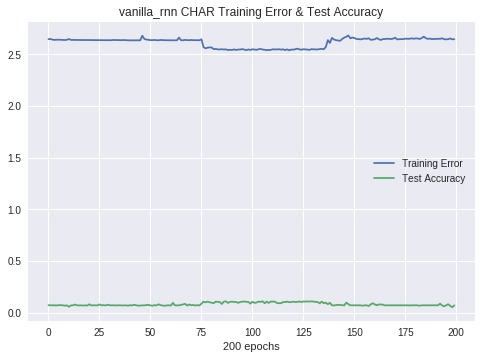

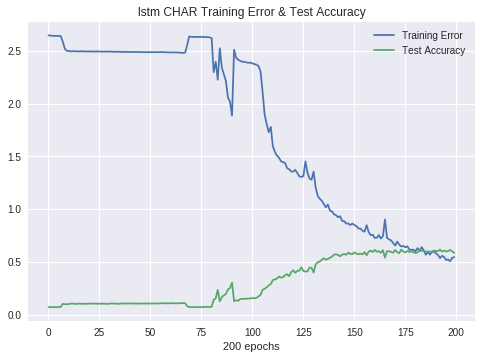

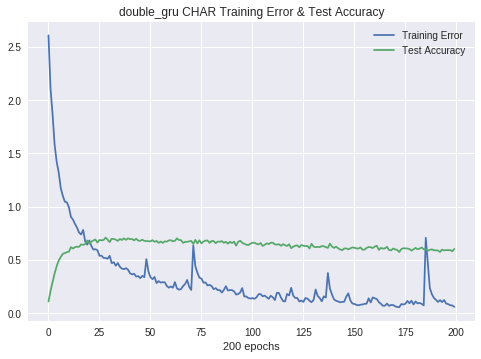

In [107]:
for cell_type in cell_types:
  tf.reset_default_graph()
  # Create the model
  x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
  y_ = tf.placeholder(tf.int64)
  keep_prob = tf.placeholder(tf.float32)

  states, logits = char_rnn_model_for_qns_6(x, cell_type)

  # Optimizer
  entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
  train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

  # Testing
  correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1)), tf.float32)
  accuracy = tf.reduce_mean(correct_prediction)

  N = len(x_train)
  idx = np.arange(N)

  # training
  training_loss = []
  testing_acc = []
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(epochs):
      np.random.shuffle(idx)
      x_train = x_train[idx]
      y_train = y_train[idx]
      for start in range(0, N-batch_size, batch_size):
        train_op.run(feed_dict={x: x_train[start: start+batch_size], y_: y_train[start: start+batch_size], keep_prob:1})

      loss_ = entropy.eval(feed_dict={x: x_train, y_: y_train, keep_prob:1})
      acc_ = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob:1})
      training_loss.append(loss_)
      testing_acc.append(acc_)


      if e%1 == 0:
        print('\riter: %d, entropy: %g, testing accuracy: %g'%(e, training_loss[e], testing_acc[e]), end='')

  plt.figure()
  plt.plot(range(epochs), training_loss)
  plt.plot(range(epochs), testing_acc)
  title = cell_type + " CHAR Training Error & Test Accuracy"
  plt.title(title)
  plt.xlabel(str(epochs)+' epochs')
  plt.legend(["Training Error", "Test Accuracy"])
  figure = "drive/NeuralNetsProject2/figures/partb/q6_" + cell_type + "_char.png"
  plt.savefig(figure)

In [0]:
x_train, y_train, x_test, y_test, n_words = data_read_words()

In [0]:
def word_rnn_model_for_qns_6(x, cell_type):
  with tf.variable_scope('qns_6_WORD'):

    word_vectors = tf.contrib.layers.embed_sequence(
        x, vocab_size=n_words, embed_dim=EMBEDDING_SIZE)

    word_list = tf.unstack(word_vectors, axis=1)
    
    if cell_type == "vanilla_rnn":
      cell = tf.nn.rnn_cell.BasicRNNCell(HIDDEN_SIZE)
    elif cell_type == "lstm":
      cell = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
    elif cell_type == "double_gru":
      cell1 = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE)
      cell2 = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE)
      cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
    
    cell_dropout=tf.nn.rnn_cell.DropoutWrapper(
      cell,
      input_keep_prob=keep_prob,
      output_keep_prob=keep_prob,
      state_keep_prob=keep_prob,
    )
    
    outputs, state = tf.nn.static_rnn(cell, word_list, dtype=tf.float32)
    # state returns (c, h) of which c is cell state and h is hidden state. We want to pass hidden state to the output dense layer
    if cell_type == "double_gru" or cell_type == "lstm":
      state = state[-1]
    logits = tf.layers.dense(state, MAX_LABEL, activation=None)

  return logits

Model: vanilla_rnn, entropy: 2.6233303546905518, testing accuracy: 0.06428571790456772
Model: lstm, entropy: 0.00012512205285020173, testing accuracy: 0.7714285850524902
Model: double_gru, entropy: 5.690084890375147e-06, testing accuracy: 0.8628571629524231


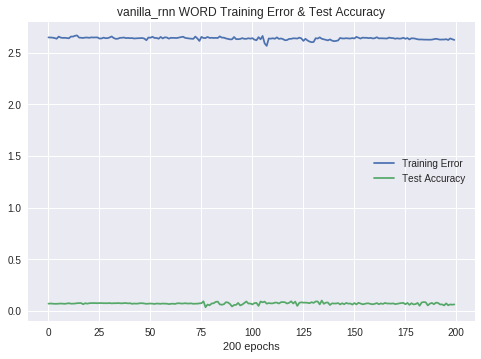

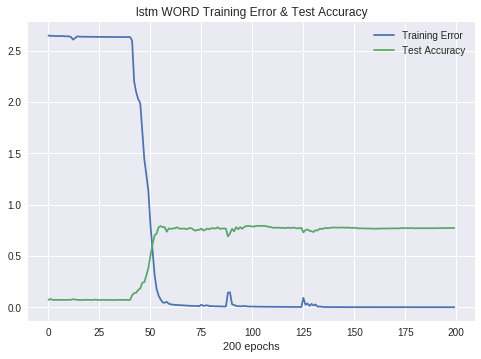

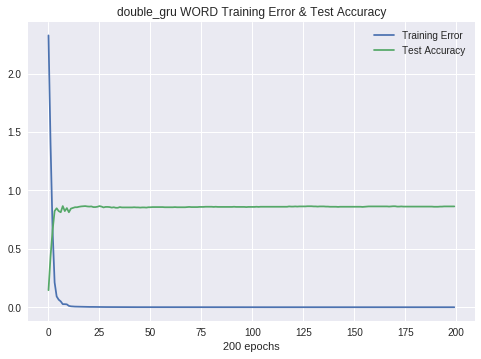

In [21]:
for cell_type in cell_types:
  tf.reset_default_graph() 
  # Create the model
  x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
  y_ = tf.placeholder(tf.int64)
  keep_prob = tf.placeholder(tf.float32)

  logits = word_rnn_model_for_qns_6(x, cell_type)

  # Optimizer
  entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
  train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

  # Testing
  correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1)), tf.float32)
  accuracy = tf.reduce_mean(correct_prediction)

  N = len(x_train)
  idx = np.arange(N)

  # training
  training_loss = []
  testing_acc = []
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(epochs):
      np.random.shuffle(idx)
      x_train = x_train[idx]
      y_train = y_train[idx]
      for start in range(0, N-batch_size, batch_size):
        train_op.run(feed_dict={x: x_train[start: start+batch_size], y_: y_train[start: start+batch_size], keep_prob:1})

      loss_ = entropy.eval(feed_dict={x: x_train, y_: y_train, keep_prob:1})
      acc_ = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob:1})
      training_loss.append(loss_)
      testing_acc.append(acc_)

  print('Model: {}, entropy: {}, testing accuracy: {}'.format(cell_type, training_loss[-1], testing_acc[-1]))

  plt.figure()
  plt.plot(range(epochs), training_loss)
  plt.plot(range(epochs), testing_acc)
  title = cell_type + " WORD Training Error & Test Accuracy"
  plt.title(title)
  plt.xlabel(str(epochs)+' epochs')
  plt.legend(["Training Error", "Test Accuracy"])
  figure = "drive/NeuralNetsProject2/figures/partb/q6_" + cell_type + "_word.png"
  plt.savefig(figure)

**Question 6 part d - Gradient Clipping**

iter: 199, entropy: 0.478501, testing accuracy: 0.445714



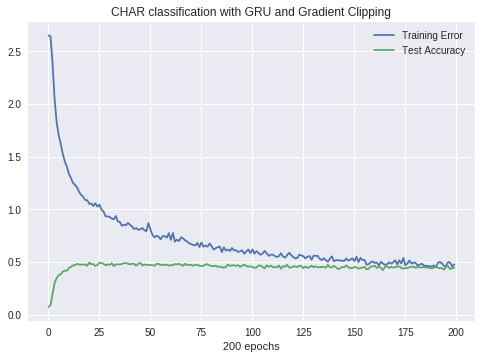

In [103]:
x_train, y_train, x_test, y_test = read_data_chars()
tf.reset_default_graph() 
# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)
keep_prob = tf.placeholder(tf.float32)

logits = char_rnn_model(x)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
#gradient clipping
train_op = tf.train.AdamOptimizer(lr)
gradients, variables = zip(*train_op.compute_gradients(entropy))
gradients, _ = tf.clip_by_global_norm(gradients, 2.0)
optimized = train_op.apply_gradients(zip(gradients, variables))

# Testing
correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(x_train)
idx = np.arange(N)

# training
training_loss = []
testing_acc = []
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for e in range(epochs):
    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]
    for start in range(0, N-batch_size, batch_size):
      optimized.run(feed_dict={x: x_train[start: start+batch_size], y_: y_train[start: start+batch_size], keep_prob:1})

    loss_ = entropy.eval(feed_dict={x: x_train, y_: y_train, keep_prob:1})
    acc_ = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob:1})
    training_loss.append(loss_)
    testing_acc.append(acc_)


    if e%1 == 0:
      print('\riter: %d, entropy: %g, testing accuracy: %g'%(e, training_loss[e], testing_acc[e]), end='')
  print("\n")

plt.figure()
plt.plot(range(epochs), training_loss)
plt.plot(range(epochs), testing_acc)
title = "CHAR classification with GRU and Gradient Clipping"
plt.title(title)
plt.xlabel(str(epochs)+' epochs')
plt.legend(["Training Error", "Test Accuracy"])
figure = "drive/NeuralNetsProject2/figures/partb/q6_d_char.png"
plt.savefig(figure)

iter: 199, entropy: 8.81124e-06, testing accuracy: 0.905714



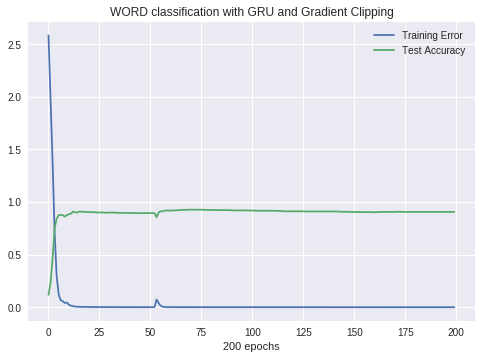

In [105]:
x_train, y_train, x_test, y_test, n_words = data_read_words()
tf.reset_default_graph() 
# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)
keep_prob = tf.placeholder(tf.float32)

logits = word_rnn_model(x)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
#gradient clipping
train_op = tf.train.AdamOptimizer(lr)
gradients, variables = zip(*train_op.compute_gradients(entropy))
gradients, _ = tf.clip_by_global_norm(gradients, 2.0)
optimized = train_op.apply_gradients(zip(gradients, variables))

# Testing
correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(x_train)
idx = np.arange(N)

# training
training_loss = []
testing_acc = []
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for e in range(epochs):
    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]
    for start in range(0, N-batch_size, batch_size):
      optimized.run(feed_dict={x: x_train[start: start+batch_size], y_: y_train[start: start+batch_size], keep_prob:1})

    loss_ = entropy.eval(feed_dict={x: x_train, y_: y_train, keep_prob:1})
    acc_ = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob:1})
    training_loss.append(loss_)
    testing_acc.append(acc_)


    if e%1 == 0:
      print('\riter: %d, entropy: %g, testing accuracy: %g'%(e, training_loss[e], testing_acc[e]), end='')
  print("\n")

plt.figure()
plt.plot(range(epochs), training_loss)
plt.plot(range(epochs), testing_acc)
title = "WORD classification with GRU and Gradient Clipping"
plt.title(title)
plt.xlabel(str(epochs)+' epochs')
plt.legend(["Training Error", "Test Accuracy"])
figure = "drive/NeuralNetsProject2/figures/partb/q6_d_word.png"
plt.savefig(figure)